# Investigation of the Lahman Baseball Dataset

<br/>We will investigate the Lahman baseball database in order to answer the following questions:

<li>What are some differences between winning teams and non-winning teams and their performances?</li>
<li>What are the 10 most winningest MLB franchises?</li>
<li>What are some commonalities among those 10 franchises?</li>

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

%pylab inline

# Load DataFrames from CSVs in lahman-csv folder

team_df = pd.read_csv('lahman-csv//teams.csv')
player_df = pd.read_csv('lahman-csv//master.csv')
salary_df = pd.read_csv('lahman-csv//salaries.csv')

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Change Y/N to booleans
# This will come in handy later for counting wins for each team
team_df['DivWin'] = team_df.DivWin == 'Y'
team_df['WCWin'] = team_df.WCWin == 'Y'
team_df['LgWin'] = team_df.LgWin == 'Y'
team_df['WSWin'] = team_df.WSWin == 'Y'

# Add win percentage column
team_df['win_pct'] = team_df['W'] / team_df['G']

In [4]:
team_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2775 entries, 0 to 2774
Data columns (total 49 columns):
yearID            2775 non-null int64
lgID              2725 non-null object
teamID            2775 non-null object
franchID          2775 non-null object
divID             1258 non-null object
Rank              2775 non-null int64
G                 2775 non-null int64
Ghome             2376 non-null float64
W                 2775 non-null int64
L                 2775 non-null int64
DivWin            2775 non-null bool
WCWin             2775 non-null bool
LgWin             2775 non-null bool
WSWin             2775 non-null bool
R                 2775 non-null int64
AB                2775 non-null int64
H                 2775 non-null int64
2B                2775 non-null int64
3B                2775 non-null int64
HR                2775 non-null int64
BB                2775 non-null int64
SO                2655 non-null float64
SB                2631 non-null float64
CS           

## Missing Data
There is no pre-2000 data for hits by pitcher (HBP) or sacrifice flies (SF). These metrics will be ignored in the analysis.<br/>The following metrics are missing data values:
<br/>
SO<br/>SB<br/>CS<br/>DP
<br/><br/>
Let's take a look at how each metric trends over time to determine the best way to fill missing values.

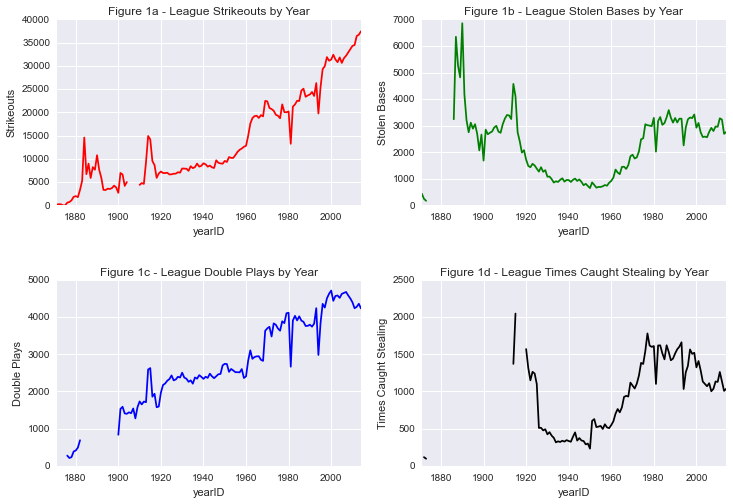

In [5]:
# Find/Fill in missing values for SO,SB,CS,DP
teams_by_year = team_df.groupby('yearID')
sums = teams_by_year.sum()
fig,axs = plt.subplots(2,2)
fig.set_figwidth(fig.get_figwidth()*2)
fig.set_figheight(fig.get_figheight()*2)
fig.subplots_adjust(hspace=0.4)
sums['SO'].plot(ax=axs[0][0],color="red")
sums['SB'].plot(ax=axs[0][1],color="green")
sums['DP'].plot(ax=axs[1][0],color="blue")
sums['CS'].plot(ax=axs[1][1],color="black")
axs[0][0].set_ylabel("Strikeouts")
axs[0][1].set_ylabel("Stolen Bases")
axs[1][0].set_ylabel("Double Plays")
axs[1][1].set_ylabel("Times Caught Stealing")
axs[0][0].set_title("Figure 1a - League Strikeouts by Year")
axs[0][1].set_title("Figure 1b - League Stolen Bases by Year")
axs[1][0].set_title("Figure 1c - League Double Plays by Year")
axs[1][1].set_title("Figure 1d - League Times Caught Stealing by Year")

In [6]:
# Compute fill values based on other metrics
so_pct = team_df['SO'] / team_df['AB']
mean_so_pct = so_pct.mean()
print "ratio of strikeouts to number of at bats = ", mean_so_pct
fills = team_df['AB'] * mean_so_pct
team_df['SO'] = team_df['SO'].fillna(fills)
mean_steal_pct = (team_df['SB']/team_df['H']).mean()
print "ratio of stolen bases to number of hits = ", mean_steal_pct
fills = team_df['H'] * mean_steal_pct
team_df['SB'] = team_df['SB'].fillna(fills)
mean_pct = np.mean((sums['CS']/sums['SB']))
print "ratio of times caught stealing to stolen bases = ", mean_pct
fills = team_df['SB'] * mean_pct
team_df['CS'] = team_df['CS'].fillna(fills)
# Total chances to field the ball (TC)
team_TC = team_df['E'] / (1 - team_df['FP'])
means = teams_by_year.mean()
TC = sums['E'] / (1-means['FP'])
mean_pct = np.mean((sums['DP'] / TC))
print "ratio of double plays to total chances = ", mean_pct
fills = team_TC*mean_pct
team_df['DP'] = team_df['DP'].fillna(fills)

ratio of strikeouts to number of at bats =  0.138701575878
ratio of stolen bases to number of hits =  0.0836525775688
ratio of times caught stealing to stolen bases =  0.504651901906
ratio of double plays to total chances =  0.0258838990807


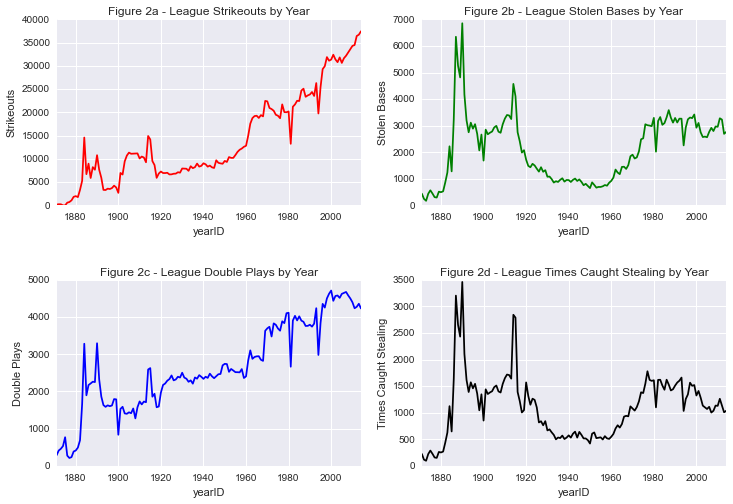

In [7]:
teams_by_year = team_df.groupby('yearID')
sums = teams_by_year.sum()
fig,axs = plt.subplots(2,2)
fig.set_figwidth(fig.get_figwidth()*2)
fig.set_figheight(fig.get_figheight()*2)
fig.subplots_adjust(hspace=0.4)
sums['SO'].plot(ax=axs[0][0],color="red")
sums['SB'].plot(ax=axs[0][1],color="green")
sums['DP'].plot(ax=axs[1][0],color="blue")
sums['CS'].plot(ax=axs[1][1],color="black")
axs[0][0].set_ylabel("Strikeouts")
axs[0][1].set_ylabel("Stolen Bases")
axs[1][0].set_ylabel("Double Plays")
axs[1][1].set_ylabel("Times Caught Stealing")
axs[0][0].set_title("Figure 2a - League Strikeouts by Year")
axs[0][1].set_title("Figure 2b - League Stolen Bases by Year")
axs[1][0].set_title("Figure 2c - League Double Plays by Year")
axs[1][1].set_title("Figure 2d - League Times Caught Stealing by Year")

## Winning Teams vs Non-winning Teams
We will separate teams into two groups--winners and non-winners. Winning teams will be those teams that have won more games than they have lost, in addition to teams that have won a wildcard or title in a single season. Non-winning teams will be those that have lost more games than they have won, i.e. sub-500 win percentage. Let's see if there are any obvious differences between the distributions of the performance metrics for winning teams and non-winning teams. <br/><br/>
**Note:** The 1981 Kansas City Royals were below .500 and still won the Division Title; they are included in the winning team set.

In [32]:
winner_flags = team_df.DivWin | team_df.WCWin | team_df.LgWin | team_df.WSWin | (team_df.win_pct > 0.500)
winning_teams = team_df[winner_flags]
nonwinning_teams = team_df[winner_flags != True]

team_df[(team_df.DivWin | team_df.WCWin | team_df.LgWin | team_df.WSWin) & (team_df.win_pct <= 0.500)]\
[['yearID','lgID','teamID','franchID','divID','name','W','L','win_pct','WCWin','DivWin','LgWin','WSWin']]

,yearID,lgID,teamID,franchID,divID,name,W,L,win_pct,WCWin,DivWin,LgWin,WSWin
1823,1981,AL,KCA,KCR,W,Kansas City Royals,50,53,0.485437,False,True,False,False


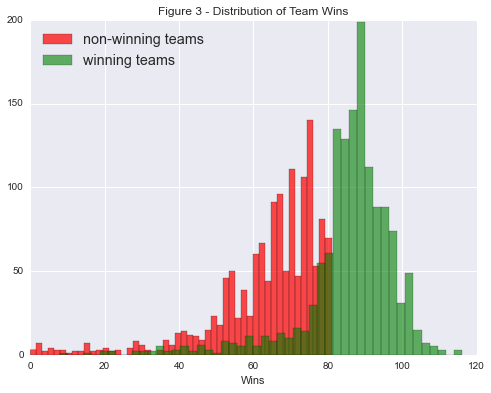

In [17]:
# Wins
plt.figure(figsize=(8,6))
plt.xlabel('Wins')
plt.title("Figure 3 - Distribution of Team Wins")
nonwinning_teams['W'].hist(color='red',bins=50,alpha=0.7)
winning_teams['W'].hist(bins=50,alpha=0.6,color='green')
plt.legend(['non-winning teams','winning teams'],loc=0,fontsize='x-large')

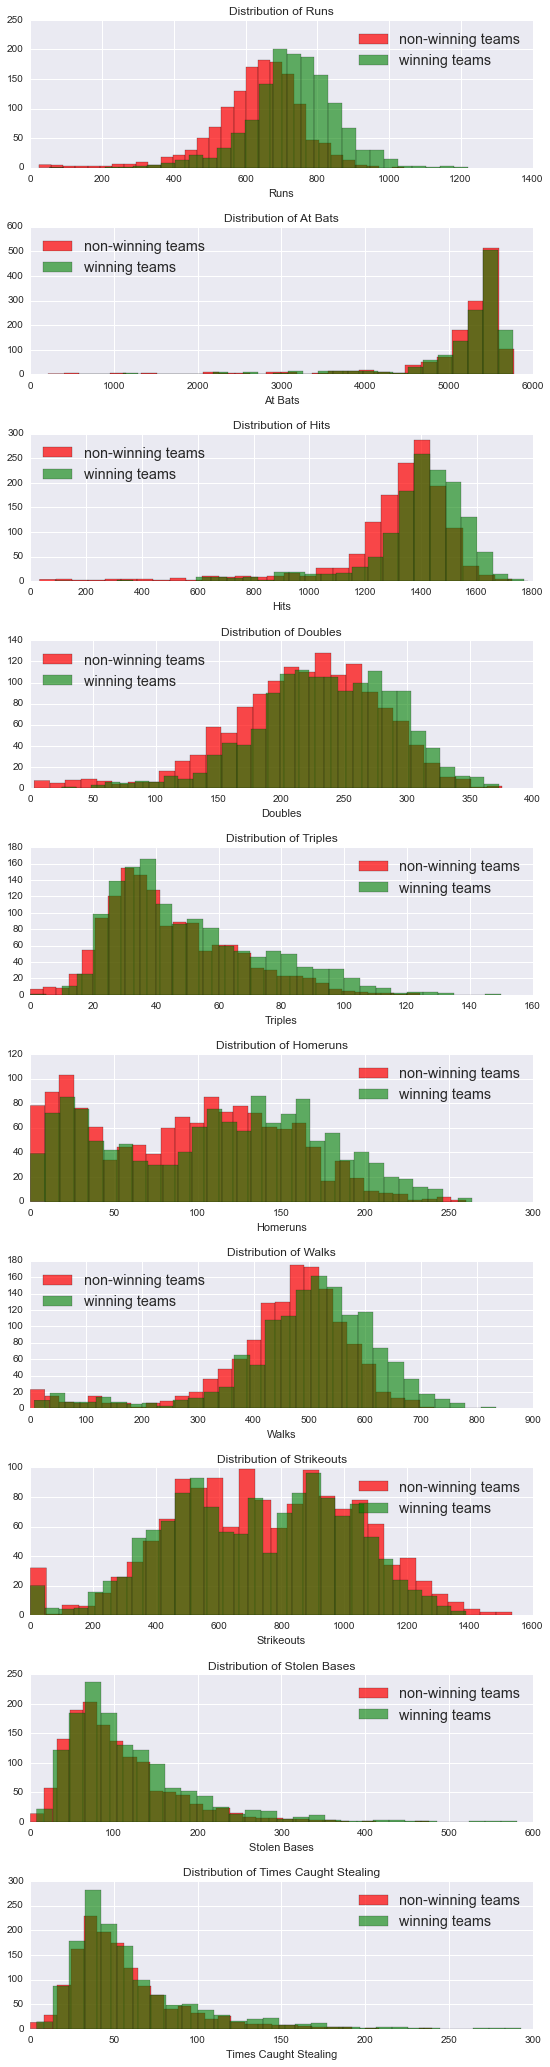

In [26]:
# Offensive metrics
fig,axs = plt.subplots(10,1)
fig.set_figwidth(fig.get_figwidth()*1.5)
fig.set_figheight(fig.get_figheight()*9)
fig.subplots_adjust(hspace=0.4)
labels = ["Runs","At Bats","Hits","Doubles","Triples","Homeruns","Walks",\
          "Strikeouts","Stolen Bases","Times Caught Stealing"]
nonwinning_teams['R'].hist(bins=30,ax=axs[0],color='red',alpha=0.7)
nonwinning_teams['AB'].hist(bins=30,ax=axs[1],color='red',alpha=0.7)
nonwinning_teams['H'].hist(bins=30,ax=axs[2],color='red',alpha=0.7)
nonwinning_teams['2B'].hist(bins=30,ax=axs[3],color='red',alpha=0.7)
nonwinning_teams['3B'].hist(bins=30,ax=axs[4],color='red',alpha=0.7)
nonwinning_teams['HR'].hist(bins=30,ax=axs[5],color='red',alpha=0.7)
nonwinning_teams['BB'].hist(bins=30,ax=axs[6],color='red',alpha=0.7)
nonwinning_teams['SO'].hist(bins=30,ax=axs[7],color='red',alpha=0.7)
nonwinning_teams['SB'].hist(bins=30,ax=axs[8],color='red',alpha=0.7)
nonwinning_teams['CS'].hist(bins=30,ax=axs[9],color='red',alpha=0.7)
winning_teams['R'].hist(bins=30,ax=axs[0],alpha=0.6,color='green')
winning_teams['AB'].hist(bins=30,ax=axs[1],alpha=0.6,color='green')
winning_teams['H'].hist(bins=30,ax=axs[2],alpha=0.6,color='green')
winning_teams['2B'].hist(bins=30,ax=axs[3],alpha=0.6,color='green')
winning_teams['3B'].hist(bins=30,ax=axs[4],alpha=0.6,color='green')
winning_teams['HR'].hist(bins=30,ax=axs[5],alpha=0.6,color='green')
winning_teams['BB'].hist(bins=30,ax=axs[6],alpha=0.6,color='green')
winning_teams['SO'].hist(bins=30,ax=axs[7],alpha=0.6,color='green')
winning_teams['SB'].hist(bins=30,ax=axs[8],alpha=0.6,color='green')
winning_teams['CS'].hist(bins=30,ax=axs[9],alpha=0.6,color='green')

for i in range(len(labels)):
    axs[i].set_xlabel(labels[i])
    axs[i].set_title("Distribution of " + labels[i])
    axs[i].legend(['non-winning teams','winning teams'],loc=0,fontsize='x-large')

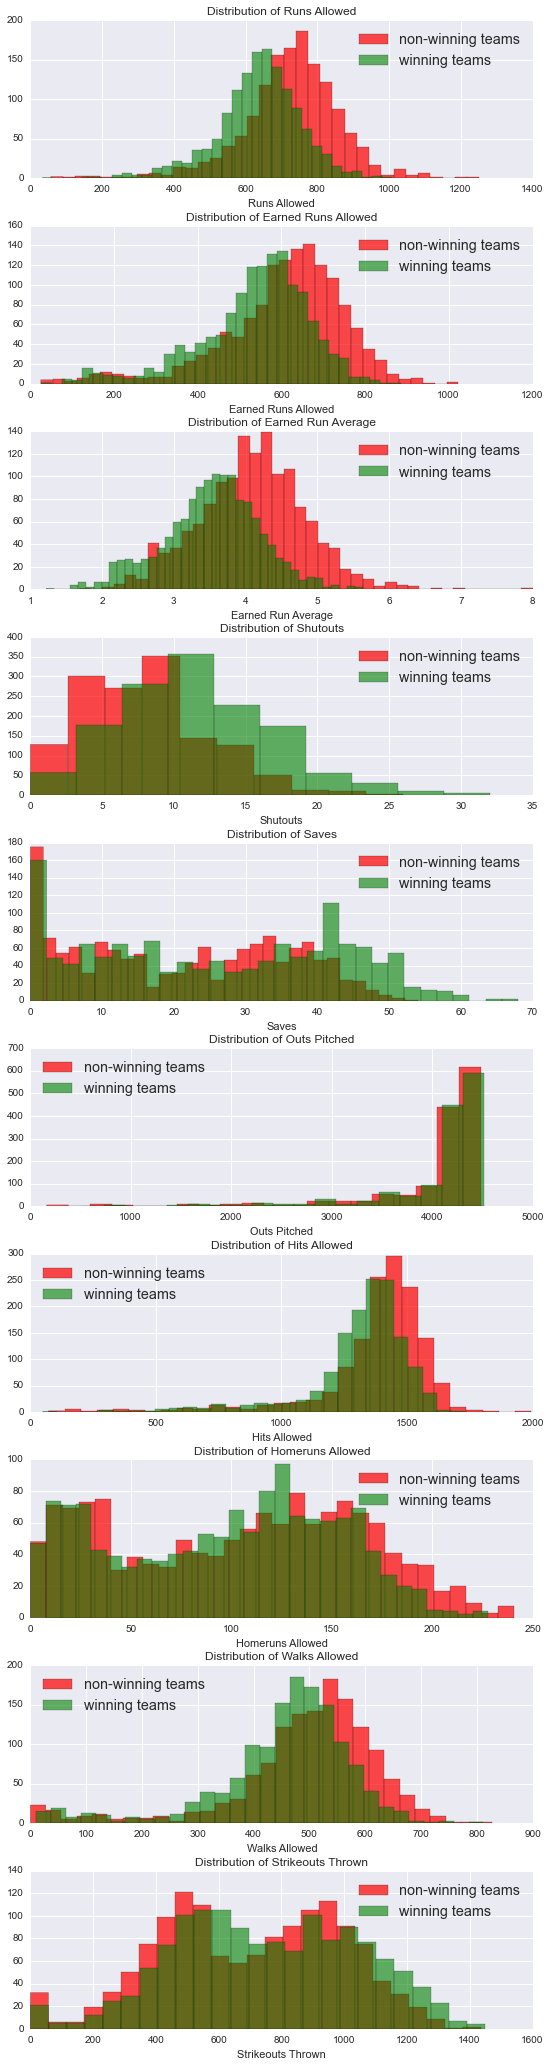

In [27]:
# Defensive metrics
fig,axs = plt.subplots(10,1)
fig.set_figwidth(fig.get_figwidth()*1.5)
fig.set_figheight(fig.get_figheight()*9)
fig.subplots_adjust(hspace=0.3)
labels = ["Runs Allowed","Earned Runs Allowed","Earned Run Average",\
          "Shutouts","Saves","Outs Pitched","Hits Allowed",\
          "Homeruns Allowed","Walks Allowed","Strikeouts Thrown"]
nonwinning_teams['RA'].hist(bins=35,ax=axs[0],alpha=0.7,color='red')
nonwinning_teams['ER'].hist(bins=35,ax=axs[1],alpha=0.7,color='red')
nonwinning_teams['ERA'].hist(bins=40,ax=axs[2],alpha=0.7,color='red')
nonwinning_teams['SHO'].hist(bins=10,ax=axs[3],alpha=0.7,color='red')
nonwinning_teams['SV'].hist(bins=30,ax=axs[4],alpha=0.7,color='red')
nonwinning_teams['IPouts'].hist(bins=20,ax=axs[5],alpha=0.7,color='red')
nonwinning_teams['HA'].hist(bins=30,ax=axs[6],alpha=0.7,color='red')
nonwinning_teams['HRA'].hist(bins=30,ax=axs[7],alpha=0.7,color='red')
nonwinning_teams['BBA'].hist(bins=30,ax=axs[8],alpha=0.7,color='red')
nonwinning_teams['SOA'].hist(bins=25,ax=axs[9],alpha=0.7,color='red')

winning_teams['RA'].hist(bins=35,ax=axs[0],color='green',alpha=0.6)
winning_teams['ER'].hist(bins=35,ax=axs[1],color='green',alpha=0.6)
winning_teams['ERA'].hist(bins=40,ax=axs[2],color='green',alpha=0.6)
winning_teams['SHO'].hist(bins=10,ax=axs[3],color='green',alpha=0.6)
winning_teams['SV'].hist(bins=30,ax=axs[4],color='green',alpha=0.6)
winning_teams['IPouts'].hist(bins=20,ax=axs[5],color='green',alpha=0.6)
winning_teams['HA'].hist(bins=30,ax=axs[6],color='green',alpha=0.6)
winning_teams['HRA'].hist(bins=30,ax=axs[7],color='green',alpha=0.6)
winning_teams['BBA'].hist(bins=30,ax=axs[8],color='green',alpha=0.6)
winning_teams['SOA'].hist(bins=25,ax=axs[9],color='green',alpha=0.6)

def label_axes(axes,labels):
    for i in range(len(labels)):
        axes[i].set_xlabel(labels[i])
        axes[i].set_title("Distribution of " + labels[i])
        axs[i].legend(['non-winning teams','winning teams'],loc=0,fontsize='x-large')

label_axes(axs,labels)

Figure 6


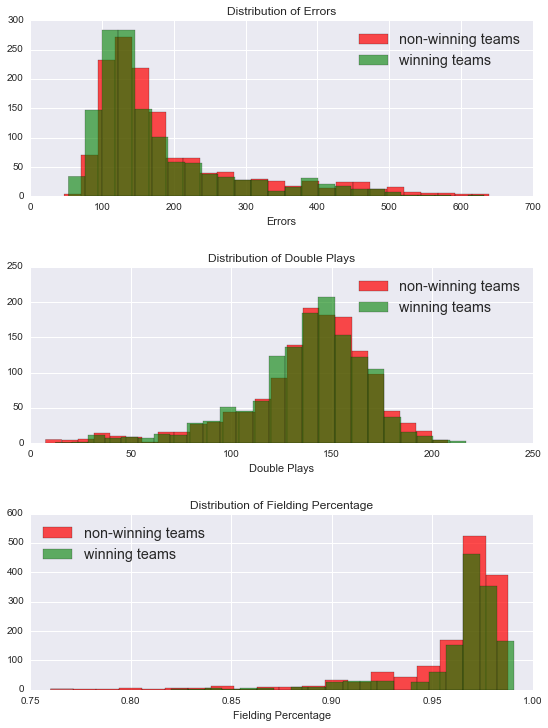

In [28]:
# More defensive metrics
fig,axs = plt.subplots(3,1)
fig.set_figwidth(fig.get_figwidth()*1.5)
fig.set_figheight(fig.get_figheight()*3)
fig.subplots_adjust(hspace=0.4)
labels = ["Errors","Double Plays","Fielding Percentage"]
nonwinning_teams['E'].hist(bins=25,ax=axs[0],color='red',alpha=0.7)
nonwinning_teams['DP'].hist(bins=25,ax=axs[1],color='red',alpha=0.7)
nonwinning_teams['FP'].hist(bins=20,ax=axs[2],color='red',alpha=0.7)

winning_teams['E'].hist(bins=25,ax=axs[0],color='green',alpha=0.6)
winning_teams['DP'].hist(bins=25,ax=axs[1],color='green',alpha=0.6)
winning_teams['FP'].hist(bins=20,ax=axs[2],color='green',alpha=0.6)
print "Figure 6"
label_axes(axs,labels)

### Computed Metrics
Other than differences in means there are no obvious differences in the distributions of the winning and non-winning teams. For further comparison, we will combine some of the metrics into more meaningful measures of performance; we will use batting average, slugging average, stolen base percentage, and the team's defensive efficiency rating.

In [30]:
# Calculate some other metrics
team_df['batting_avg'] = team_df['H'] / team_df['AB']
team_df['SLG'] = (team_df['H'] + team_df['2B'] + 2*team_df['3B'] + 3*team_df['HR'])/team_df['AB']
team_df['SBP'] = team_df['SB'] / (team_df['SB'] + team_df['CS'])
team_df['DER'] = (team_df['IPouts'] - team_df['HRA'] - team_df['SOA']) \
/ (team_df['HA'] + team_df['E'] + team_df['IPouts'] - team_df['HRA'] - team_df['SOA'])

# Add metrics to split data
winning_teams = team_df[winner_flags]
nonwinning_teams = team_df[winner_flags != True]

Figure 7


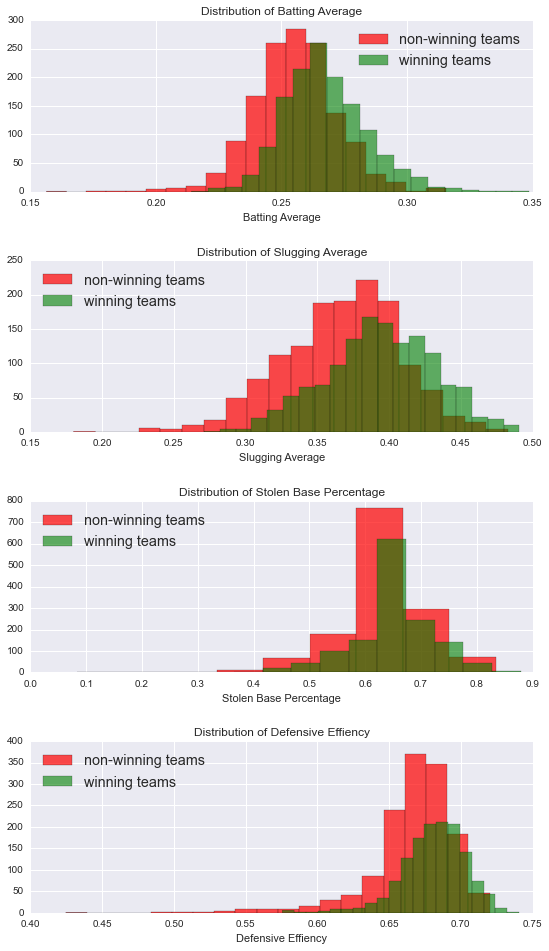

In [31]:
labels = ["Batting Average","Slugging Average",'Stolen Base Percentage',"Defensive Effiency"]
fig,axs = plt.subplots(4,1)
fig.set_figwidth(fig.get_figwidth()*1.5)
fig.set_figheight(fig.get_figheight()*4)
fig.subplots_adjust(hspace=0.4)
nonwinning_teams['batting_avg'].hist(bins=20,ax=axs[0],color='red',alpha=0.7)
nonwinning_teams['SLG'].hist(bins=20,ax=axs[1],color='red',alpha=0.7)
nonwinning_teams['SBP'].hist(bins=10,ax=axs[2],color='red',alpha=0.7)
nonwinning_teams['DER'].hist(bins=20,ax=axs[3],color='red',alpha=0.7)

winning_teams['batting_avg'].hist(bins=20,ax=axs[0],color='green',alpha=0.6)
winning_teams['SLG'].hist(bins=20,ax=axs[1],color='green',alpha=0.6)
winning_teams['SBP'].hist(bins=10,ax=axs[2],color='green',alpha=0.6)
winning_teams['DER'].hist(bins=20,ax=axs[3],color='green',alpha=0.6)
print "Figure 7"
label_axes(axs,labels)

### Statistics
Although the various distributions are similar, the metrics show that historically winning teams have performed better than non-winning teams, as expected. Table 1 below shows that winning teams have a higher batting average, on base percentage and slugging average and have had less strikeouts at bat. Winning teams also have a higher fielding percentage and defensive efficiency rating and a lower earned run average. However, differences between the metrics of winning and non-winning teams are very small. It could be hard to correlate performance metrics with winning teams. In the next section, we will find the 10 most winningest franchises and look for any correlation between those teams and the performance metrics.

In [16]:
# Combine statistics for winning teams and nonwinning teams into a single object
stats = pd.Panel({"all_teams": team_df.describe(), "winning_teams":winning_teams.describe(),"nonwinning_teams":nonwinning_teams.describe()})

In [17]:
print "Table 1 - Performance Metrics Means"
comparison = stats.loc[:,'mean',['win_pct','R','batting_avg','SLG','SBP','SO','RA','ER','ERA','CG','SHO','SV',\
                    'IPouts','HA','HRA','BBA','SOA','DP','E','FP','DER']]
comparison

Table 1 - Performance Metrics Means


,all_teams,nonwinning_teams,winning_teams
win_pct,0.495135,0.421927,0.56946
R,681.878,631.103,733.427
batting_avg,0.261525,0.255333,0.267812
SLG,0.380336,0.36676,0.394119
SBP,0.649423,0.642336,0.656609
SO,730.785,741.498,719.909
RA,681.878,727.401,635.661
ER,570.193,605.562,534.285
ERA,3.81344,4.09712,3.52543
CG,50.9892,48.4313,53.5861


## Most Winningest MLB Franchises
Major League Baseball was founded in 1903 so we will only consider teams from that year to the present. For each franchise, the total number of World Series championships, League Championship pennants, and Division Title wins will be considered. Here we will find the 10 most winningest MLB franchises and look for any correlation between those teams and the performance metrics. Figure 8 shows the total number wins for franchises.

In [34]:
mlb_teams = team_df[team_df.yearID >= 1903]
# mlb_salary_df = salary_df[salary_df.yearID > 1903]

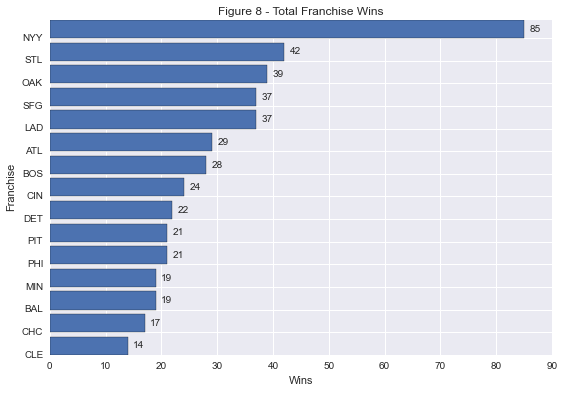

In [36]:
# Group teams by franchise
mlb_teams_by_franchise = mlb_teams.groupby('franchID')

franchise_wins = mlb_teams_by_franchise.sum()[['WSWin','LgWin','DivWin']]
franchise_wins['total_wins'] = franchise_wins.sum(axis=1)
franchise_wins = franchise_wins.sort_values('total_wins',ascending=True)
fig,ax = plt.subplots(1,1)
fig.set_figwidth(fig.get_figwidth()*1.5)
fig.set_figheight(fig.get_figheight()*1.5)
plt.xlabel("Wins")
plt.ylabel("Franchise")
plt.title("Figure 8 - Total Franchise Wins")
plt.yticks(np.arange(15),franchise_wins['total_wins'].index.values[-15:])
franch_bars = plt.barh(np.arange(15),franchise_wins['total_wins'].tail(15))
# attach some text labels
for rect in franch_bars:
    width = rect.get_width()
    ax.text(width+2., rect.get_y() + rect.get_height()/2.,
            '%d' % int(width),
            ha='center', va='center')

### Top 10
Two teams have tied for the 10th spot, the Phillies and the Pirates. In Table 2 below, we can see how these 11 franchises compare to other winning teams. Of all the metrics, the teams in the most winningest franchises on average have had higher fielding percentages than all teams, winning and non-winning.

In [37]:
franchise_df = pd.read_csv('lahman-csv//teamsfranchises.csv')
franchise_df = franchise_df.merge(franchise_wins,right_index=True,left_on="franchID").\
sort_values('total_wins',ascending=False)
print "The 10 Most Winningest MLB Franchises\n"
print franchise_df.head(11)[['franchName','total_wins']].to_string(index=False)

The 10 Most Winningest MLB Franchises

            franchName  total_wins
      New York Yankees          85
   St. Louis Cardinals          42
     Oakland Athletics          39
   Los Angeles Dodgers          37
  San Francisco Giants          37
        Atlanta Braves          29
        Boston Red Sox          28
       Cincinnati Reds          24
        Detroit Tigers          22
 Philadelphia Phillies          21
    Pittsburgh Pirates          21


In [21]:
topten_df = mlb_teams[mlb_teams['franchID'].isin(franchise_df.head(11)['franchID'])]
topten_stats = topten_df.describe()
comparison['top_ten_franchises'] = topten_stats.loc['mean',['win_pct','R','batting_avg','SLG',\
                                                            'SBP','SO','RA','ER','ERA','CG','SHO','SV',\
                                                            'IPouts','HA','HRA','BBA',\
                                                            'SOA','DP','E','FP','DER']]
print "Table 2 - Comparison of Means"
comparison

Table 2 - Comparison of Means


,all_teams,nonwinning_teams,winning_teams,top_ten_franchises
win_pct,0.495135,0.421927,0.56946,0.508677
R,681.878,631.103,733.427,693.793
batting_avg,0.261525,0.255333,0.267812,0.262768
SLG,0.380336,0.36676,0.394119,0.385785
SBP,0.649423,0.642336,0.656609,0.643933
SO,730.785,741.498,719.909,752.142
RA,681.878,727.401,635.661,677.53
ER,570.193,605.562,534.285,583.775
ERA,3.81344,4.09712,3.52543,3.75824
CG,50.9892,48.4313,53.5861,49.7078


## Statistical Test
Table 2 above shows the comparison of the most winningest franchises and the other data sets.<br/><br/>
The teams in the most winningest franchises on average have had higher fielding percentages. We will use a stastical test to determine if winning teams have higher fielding percentages than non-winning teams. The null hypothesis is there is no difference between the fielding percentages of winning and non-winning teams. The alternative hypothesis is there is a difference between the fielding percentages of winning teams and non-winning teams, and we expect the fielding percentage of winning teams to be greater. We will take a random sample of winning teams and non-winning teams and use a two-tailed t-test with alpha = 0.5.

In [44]:
import scipy.stats

# The sample of winning MLB teams will be those who have won a title (Division, League, or World Series)
winner_flags = mlb_teams.DivWin | mlb_teams.LgWin | mlb_teams.WSWin
winners = mlb_teams[winner_flags]
nonwinners = mlb_teams[winner_flags != True]
t,p = scipy.stats.ttest_ind(winners['FP'].sample(100),nonwinners['FP'].sample(250),equal_var=False)
print "t =",t,", p =", p

t = 6.01539159267 , p = 7.93732189357e-09


At 𝛼 = .05, we reject the null hypothesis. As expected, winners have significantly higher fielding percentages than non-winners with p < .001. According to Wikipedia, fielding percentage is the ratio of total plays (total chances minus errors) to the number of total chances. Figure 9 below shows the relationship between a team's errors and its win percentage. Pearson's r shows a small association between errors and win percentage; as errors increase, the number of wins, or a team's win percentage, decreases. 

Pearson's r = -0.217042331074


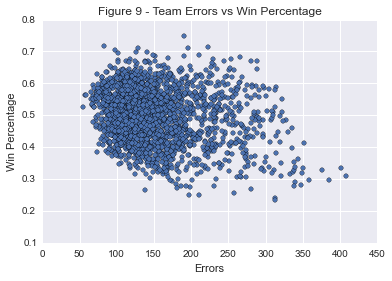

In [46]:
mlb_teams.plot(x='E',y='win_pct',kind='scatter')
plt.title("Figure 9 - Team Errors vs Win Percentage")
plt.xlabel('Errors')
plt.ylabel('Win Percentage')
corrcoeffs = mlb_teams.corr()
print "Pearson's r =", corrcoeffs.loc['E','win_pct']

## Conclusion
We can see there is a small correlation between team errors and its win percentage; as errors increase, a team's win percentage decreases. Other factors contribute to a team's win percentage. We can compare the statistics in Table 2 and observe the differences in means between the most winningest franchises, winning teams, and non-winning teams. However, the mean may not be the best measure of central tendency for each metric; not all of the distributions are normal or unimodal.<br/><br/>
Each sample point in the dataset is defined by a team's single season performance. Using the team's performance metrics was not the only way to compare winning and non-winning teams. A team goes through a number of changes throughout a single season. Personnel changes and individual player performance contribute to a team's performance. Teams' performances could have been compared between the first and second half of the season to help isolate other contributing factors.<br/><br/>
Also there were numerous gaps in time in the dataset for some metrics. Missing data values were computed using other metrics. We cannot be certain this is the best way to fill the missing data. Using this method, it is possible for errors to propagate through to other metrics since fill values are based on other data, some of which is also missing. And since fill values are derived from other data, the new values also follow the trends of the data they are based upon. Therefore we cannot be sure of the accuracy of the fill values. We could have used the mean of each metric to fill data. We could have also used a moving average to fill missing data to follow the trends over time. Fill values would have been isolated from other metrics, but sometimes that is not the case in real life.<br/><br/>
The comparison between winning and non-winning teams will provide a starting point for further analysis. We still cannot predict a team's performance based on the analysis provided. Individual player contribution to the team may also need to be included. Additional analysis will be needed to determine all contributing factors to the win percentage in order to predict a team's performance.

## Resources

Adler, J. (2005). Baseball Hacks. Sebastopol, Calif: O'Reilly.

Baseball statistics. (2015, October 24). In Wikipedia, The Free Encyclopedia. Retrieved 05:27, November 23, 2015, from https://en.wikipedia.org/w/index.php?title=Baseball_statistics&oldid=687228510

Major League Baseball. (2015, November 12). In Wikipedia, The Free Encyclopedia. Retrieved 04:43, November 13, 2015, from https://en.wikipedia.org/w/index.php?title=Major_League_Baseball&oldid=690367504

http://www.seanlahman.com/baseball-archive/statistics/ [Accessed lahman-csv_2015-01-24.zip, November 12, 2015]